In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# pip install xgboost catboost

In [2]:
df = pd.read_csv(r"C:\Users\sande\OneDrive\Desktop\Hydraulic Sales ML cp dataset\hydraulic_sales.csv")

In [3]:
df.head()

,date,product_type,product_code,variant,region,country,customer_segment,channel,application_area,units_sold,...,lead_time_days,competitor_activity,seasonality_index,economic_indicator,new_product_launch,failure_rate_pct,return_units,pressure_rating_bar,temperature_rating_c,oil_type
0,2020-01,External Gear Pump,GP-200,30cc,North,India,OEM,Dealer,Construction,76,...,5,4,0.96,6.04,0,1.27,0,315,110,HLP46
1,2020-01,External Gear Pump,GP-200,30cc,North,India,OEM,Offline,Construction,72,...,18,1,0.90,8.18,1,1.14,2,160,80,HVLP68
2,2020-01,External Gear Pump,GP-200,20cc,North,India,OEM,Offline,Construction,282,...,6,0,1.17,5.58,0,1.06,1,200,100,HVLP46
3,2020-01,External Gear Pump,GP-200,20cc,North,India,OEM,Dealer,Industrial,256,...,13,0,1.02,6.25,0,2.39,2,315,100,HLP68
4,2020-01,External Gear Pump,GP-200,30cc,North,India,OEM,Offline,Industrial,274,...,15,6,1.24,6.85,1,0.41,3,200,80,HLP68


In [4]:
df.shape

(230400, 24)

In [5]:
df.describe()

,units_sold,revenue,marketing_spend,discount_percent,stock_available,lead_time_days,competitor_activity,seasonality_index,economic_indicator,new_product_launch,failure_rate_pct,return_units,pressure_rating_bar,temperature_rating_c
count,230400.000000,2.280450e+05,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000
mean,172.867339,1.039705e+06,32638.828485,8.502270,299.327365,12.001476,4.504227,1.049905,7.000114,0.100582,1.298217,1.998845,255.134332,95.016319
std,73.764655,4.309072e+05,31277.026880,3.458809,115.386358,4.318122,2.869779,0.115476,0.865525,0.300775,0.693358,1.415483,70.319620,11.175304
min,-5.000000,2.500000e+05,10000.000000,3.000000,100.000000,5.000000,0.000000,0.850000,5.500000,0.000000,0.100000,0.000000,160.000000,80.000000
25%,110.000000,6.660000e+05,20050.000000,5.000000,199.000000,8.000000,2.000000,0.950000,6.250000,0.000000,0.700000,1.000000,200.000000,90.000000
50%,173.000000,1.038000e+06,30204.000000,8.000000,300.000000,12.000000,5.000000,1.050000,7.000000,0.000000,1.290000,2.000000,250.000000,100.000000
75%,236.000000,1.410000e+06,40267.000000,12.000000,399.000000,16.000000,7.000000,1.150000,7.750000,0.000000,1.900000,3.000000,315.000000,110.000000
max,299.000000,1.794000e+06,499750.000000,14.000000,499.000000,19.000000,9.000000,1.250000,8.500000,1.000000,2.500000,4.000000,350.000000,110.000000


In [6]:
df.isnull().sum()[df.isnull().sum()>0]

product_code    2256
revenue         2355
dtype: int64

In [7]:
df.dtypes

date                     object
product_type             object
product_code             object
variant                  object
region                   object
country                  object
customer_segment         object
channel                  object
application_area         object
units_sold                int64
revenue                 float64
marketing_spend           int64
discount_percent          int64
stock_available           int64
lead_time_days            int64
competitor_activity       int64
seasonality_index       float64
economic_indicator      float64
new_product_launch        int64
failure_rate_pct        float64
return_units              int64
pressure_rating_bar       int64
temperature_rating_c      int64
oil_type                 object
dtype: object

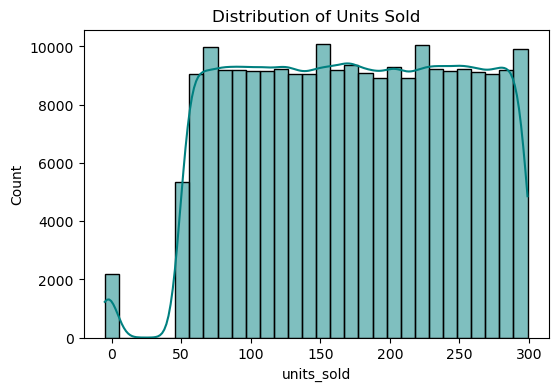

In [8]:
# Distribution of Target
plt.figure(figsize=(6,4))
sns.histplot(df['units_sold'], bins=30, kde=True, color='teal')
plt.title('Distribution of Units Sold')
plt.show()
    
# The target variable units_sold is almost uniformly distributed between 50 and 300 units, 
# with a small concentration near zero. This means the model must learn patterns across the whole range 
# rather than focusing on a single peak (not a normal distribution).

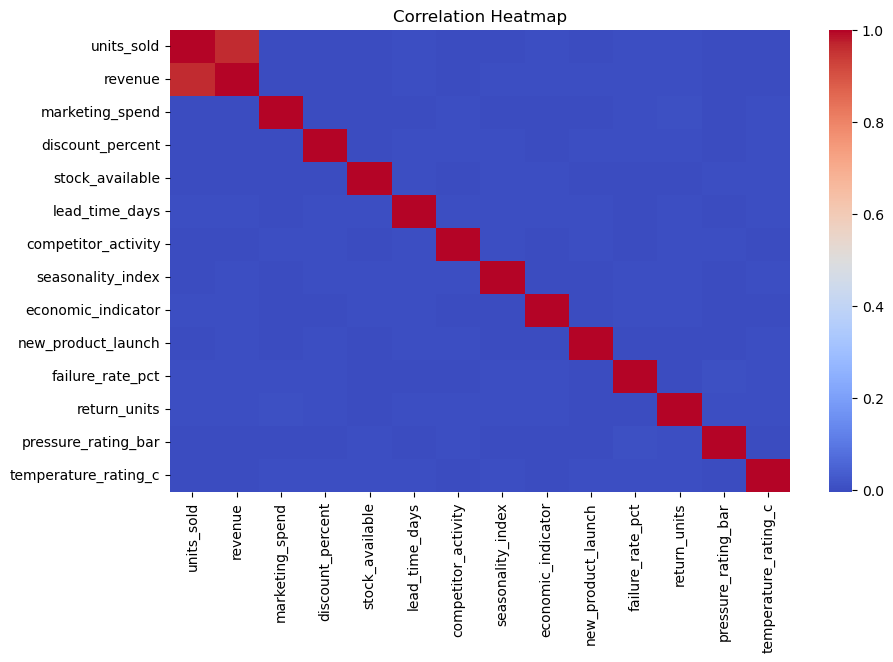

In [9]:
# Corr Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

# Dark red on diagonal = each feature perfectly correlated with itself (1.0).
# units_sold is very strongly positively correlated with revenue (r ≈ 0.96), 
# which is expected because revenue is essentially units × price. Other numeric features show low pairwise correlations, 
# so multicollinearity is not a big issue and each feature can contribute independent information to the model.

In [10]:
df[['units_sold','revenue']].corr()

,units_sold,revenue
units_sold,1.000000,0.963726
revenue,0.963726,1.000000


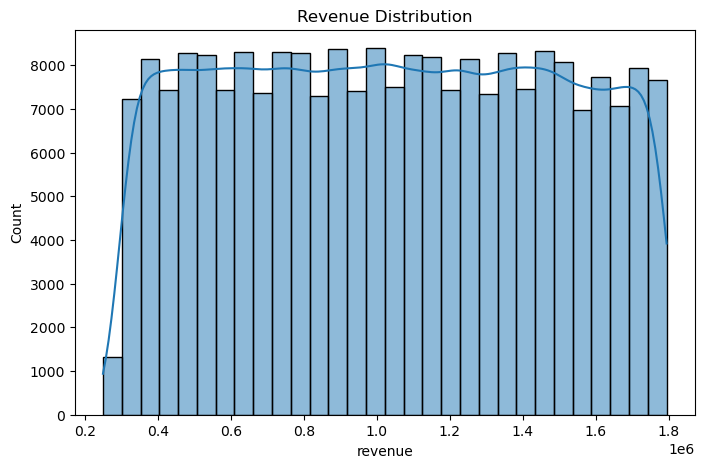

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(df['revenue'], bins=30, kde=True)
plt.title('Revenue Distribution')
plt.show()

# Revenue values are spread fairly evenly across the range, indicating a variety of order sizes rather than a single dominant ticket size. 
# Combined with the strong correlation to units_sold, this supports the consistency of pricing structure in the data.

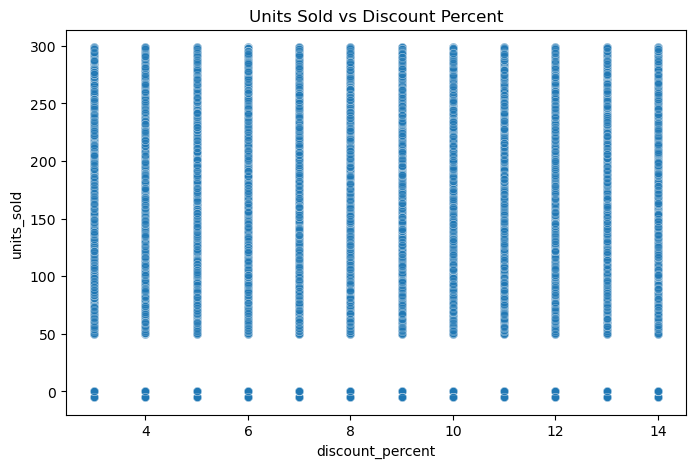

In [12]:
# Discount Percent — Units Sold vs Discount

plt.figure(figsize=(8,5))
sns.scatterplot(x=df['discount_percent'], y=df['units_sold'], alpha=0.3)
plt.title("Units Sold vs Discount Percent")
plt.show()


In [13]:
df['oil_type'].unique()

array(['HLP46', 'HVLP68', 'HVLP46', 'HLP68'], dtype=object)

In [14]:
df['product_code'].value_counts()

product_code
DCV-315    218277
GP-200       9867
Name: count, dtype: int64

In [15]:
# We cleaned product_type by merging spelling variations and duplicate names like ‘External Gear Pump’ and ‘Extrnal Gear Pump’ into ‘Gear Pump’.
# This reduces noise and improves the accuracy of encoding and the ML model.

df['product_type'] = df['product_type'].replace({
    'External Gear Pump': 'Gear Pump',
    'Extrnal Gear Pump': 'Gear Pump',
    'DC Valve': 'Directional Control Valve',
    'DCV Valve': 'Directional Control Valve'})

In [16]:
df['product_code'] = df['product_code'].fillna('Unknown')
df['revenue'] = df['revenue'].fillna(df['revenue'].median())
df['units_sold'] = df['units_sold'].clip(lower=0)

In [17]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df = df.drop(columns=['date'])

In [18]:
cat_cols = ['product_type', 'product_code', 'variant', 'region', 'country',
            'customer_segment', 'channel', 'application_area', 'oil_type']

In [19]:
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

# Save encoders
import pickle
pickle.dump(encoders, open("label_encoders.pkl", "wb"))

In [20]:
df.head()

,product_type,product_code,variant,region,country,customer_segment,channel,application_area,units_sold,revenue,...,failure_rate_pct,return_units,pressure_rating_bar,temperature_rating_c,oil_type,year,month,quarter,month_sin,month_cos
0,1,1,4,1,2,2,0,1,76,380000.0,...,1.27,0,315,110,0,2020,1,1,0.5,0.866025
1,1,1,4,1,2,2,2,1,72,360000.0,...,1.14,2,160,80,3,2020,1,1,0.5,0.866025
2,1,1,2,1,2,2,2,1,282,1410000.0,...,1.06,1,200,100,2,2020,1,1,0.5,0.866025
3,1,1,2,1,2,2,0,2,256,1280000.0,...,2.39,2,315,100,1,2020,1,1,0.5,0.866025
4,1,1,4,1,2,2,2,2,274,1370000.0,...,0.41,3,200,80,1,2020,1,1,0.5,0.866025


In [21]:
X = df.drop(columns=['units_sold'])
y = df['units_sold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Linear Regression
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

print("\n🔹 Linear Regression Results 🔹")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²  :", r2_score(y_test, y_pred))


🔹 Linear Regression Results 🔹
MAE : 5.020383223491681
RMSE: 20.71774580348477
R²  : 0.9210525707198931


In [23]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

rfc = RandomForestRegressor(n_estimators=200, random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print("\n🔹 Random Forest Results 🔹")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²  :", r2_score(y_test, y_pred))


🔹 Random Forest Results 🔹
MAE : 4.985224283854166
RMSE: 21.040191274684876
R²  : 0.9185760138250151


In [24]:
# XGBoost
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print("\n🔹 XGBoost Results 🔹")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²  :", r2_score(y_test, y_pred))


🔹 XGBoost Results 🔹
MAE : 4.095626520365476
RMSE: 20.422255306377426
R²  : 0.9232885241508484


In [25]:
# LightGBM
from lightgbm import LGBMRegressor

lgb = LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
lgb.fit(X_train, y_train)

y_pred = lgb.predict(X_test)

print("\n🔹 LightGBM Results 🔹")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²  :", r2_score(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1420
[LightGBM] [Info] Number of data points in the train set: 184320, number of used features: 27
[LightGBM] [Info] Start training from score 172.907058

🔹 LightGBM Results 🔹
MAE : 4.0311893564373005
RMSE: 20.37203779806544
R²  : 0.9236653112542822


In [26]:
# Save model

pickle.dump(lgb, open("lightgbm_model.pkl", "wb"))

In [27]:
results = pd.DataFrame({
    'Actual_Units_Sold': y_test.values,
    'Predicted_Units_Sold': np.round(y_pred, 2)})

In [28]:
# Add error column for better insight
results['Error'] = results['Actual_Units_Sold'] - results['Predicted_Units_Sold']

In [29]:
# Save to CSV file
results.to_csv("test_predictions.csv", index=False)

In [30]:
print("✅ Test predictions saved successfully as 'test_predictions.csv'")
print(results.head(10))

✅ Test predictions saved successfully as 'test_predictions.csv'
   Actual_Units_Sold  Predicted_Units_Sold  Error
0                217                214.45   2.55
1                242                242.67  -0.67
2                 81                 80.05   0.95
3                 56                 55.36   0.64
4                 60                 59.64   0.36
5                151                149.53   1.47
6                249                245.98   3.02
7                 72                 71.68   0.32
8                138                136.20   1.80
9                 53                 53.54  -0.54


In [31]:
# For rounded

results['Predicted_Units_Sold'] = results['Predicted_Units_Sold'].round().astype(int)
results['Error'] = results['Actual_Units_Sold'] - results['Predicted_Units_Sold']
results.to_csv("test_predictions_rounded.csv", index=False)

print("✅ Rounded test predictions saved as 'test_predictions_rounded.csv'")
print(results.head(10))

✅ Rounded test predictions saved as 'test_predictions_rounded.csv'
   Actual_Units_Sold  Predicted_Units_Sold  Error
0                217                   214      3
1                242                   243     -1
2                 81                    80      1
3                 56                    55      1
4                 60                    60      0
5                151                   150      1
6                249                   246      3
7                 72                    72      0
8                138                   136      2
9                 53                    54     -1


In [ ]:
# command prompt
# streamlit run hydro.py